<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/USE_finetuning_YouTube_clickbait_all_ADAMW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Thu Jul 22 09:25:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 34.1 MB/s 
     |████████████████████████████████| 1.6 MB 41.3 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
     |████████████████████████████████| 211 kB 57.1 MB/s 
     |████████████████████████████████| 636 kB 48.2 MB/s 
     |████████████████████████████████| 352 kB 68.6 MB/s 
     |████████████████████████████████| 1.2 MB 47.6 MB/s 
     |████████████████████████████████| 679 kB 56.3 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 99 kB 12.0 MB/s 


#Imports

In [4]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score



import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [5]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Sentence encoder configs

In [6]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
USE_layer = hub.KerasLayer(
    encoder,
    input_shape=[],
    dtype=tf.string, 
    trainable=True, name='USE_embedding')

##General config

In [7]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'
fvc_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/FVC_CORPUS/tfrec_data/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_USE_all'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all'
if not os.path.exists(checkpoint_root_path):
    os.makedirs(checkpoint_root_path)
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_USE_all_checkpoint' )


BATCH_SIZE = 32  
# Label categories
label_list = [0,1]

init_lr = 1e-4

epochs = 30

#Scripts

In [8]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [9]:
#@title "Utilities [Create Model Definition]"
def create_model():

 model = tf.keras.models.Sequential()
 model.add(USE_layer)
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(128, activation='relu'))
 model.add(tf.keras.layers.BatchNormalization())
 model.add(tf.keras.layers.Dropout(0.2))
 model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 return model

In [10]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [11]:
#@title "Utilities [Visualization]"
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [12]:
#@title "Utilities [Gradient function]"
#https://keras.io/examples/vision/gradient_centralization/#implement-gradient-centralization
from tensorflow.keras.optimizers import RMSprop
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [13]:
class LearningRateDecay:
	def plot(self, epochs, title="Learning Rate Schedule"):
		# compute the set of learning rates for each corresponding
		# epoch
		lrs = [self(i) for i in epochs]
		# the learning rate schedule
		plt.style.use("ggplot")
		plt.figure()
		plt.plot(epochs, lrs)
		plt.title(title)
		plt.xlabel("Epoch #")
		plt.ylabel("Learning Rate")

class StepDecay(LearningRateDecay):
	def __init__(self, initAlpha=0.01, factor=0.25, dropEvery=10):
		# store the base initial learning rate, drop factor, and
		# epochs to drop every
		self.initAlpha = initAlpha
		self.factor = factor
		self.dropEvery = dropEvery
	def __call__(self, epoch):
		# compute the learning rate for the current epoch
		exp = np.floor((1 + epoch) / self.dropEvery)
		alpha = self.initAlpha * (self.factor ** exp)
		# return the learning rate
		return float(alpha)

class PolynomialDecay(LearningRateDecay):
	def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
		# store the maximum number of epochs, base learning rate,
		# and power of the polynomial
		self.maxEpochs = maxEpochs
		self.initAlpha = initAlpha
		self.power = power
	def __call__(self, epoch):
		# compute the new learning rate based on polynomial decay
		decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
		alpha = self.initAlpha * decay
		# return the new learning rate
		return float(alpha)

#Read TFRecord data

In [14]:
#@title  "Load files & Split into Train and Val"

# read tfrec files from disk storage
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_fvc_clickbait_data = read_tfrec_data(fvc_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

fvc_filenames, fvc_training_filenames, fvc_validation_filenames, fvc_testing_filenames = read_fvc_clickbait_data.get_tfrec_files()


filenames = YouTube_filenames + stop_clickbait_filenames + fvc_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames + fvc_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames + fvc_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

print(f'Length FileNames : {len(filenames)} Length Training FileNames : {len(training_filenames)} Length Validation FileNames : {len(validation_filenames)}')

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames) + 100 * len(fvc_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames) + 100 * len(fvc_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
Pattern matches 16 data files. Splitting dataset into 13 training files , 3 validation files and 0 test files
Length FileNames : 94 Length Training FileNames : 77 Length Validation FileNames : 17
With a batch size of 32, there will be 1207 batches per training epoch and 266 batch(es) per validation run.


In [15]:
#@title  "Load Test and Benchmarking files"
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1) # Used only for benchmarking


testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

len(testing_filenames), len(benchmarking_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


(2, 4)

#Load TFRecord into TF Dataset

In [16]:
# create the TF datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)
  benchmark_ds = load_dataset(benchmarking_filenames)

In [17]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'the sinister reason weed is illegal surprise nixon had zero chill adamruinseverything watch an all new adam ruins everything on trutv every tuesday c catch up with clips full episodes of adam ruins everything at trutv com adamruinseverything like adam ruins everything on facebook at facebook com trutvadamruinseverything follow adam ruins everything on twitter at twitter com adamruins see more like us on follow us on follow us on', class : 0, label : b'nonclickbaits'
text : b'omggggg minecraft video youtubers life with morgz omg we start a minecraft lets play today we have episode of a hilarious new game called youtubers life in this game we try and grow a youtube channel and gain subscribers fast it s not actually real though it gets a bit confusing anyway this game was so fun to play and i had such a laugh growing a channel and starting that minecraft lets play if you want to see the next episode of this epic series then lets smash likes if we hit that you will see part three

In [18]:
# We need only Text and numeric Label from the dataset
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))
  benchmark_ds = benchmark_ds.map(lambda text, class_num, label:(text, class_num))

In [19]:
train_ds.element_spec, val_ds.element_spec, test_ds.element_spec, benchmark_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.int64, name=None)))

In [20]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)
  benchmark_ds = get_batched_dataset(benchmark_ds)

#Modeling

##Build classifier

In [21]:
classifier_model = create_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 256,864,129
Trainable params: 256,863,873
Non-trainable params: 256
________________________________________

##Train classifier model

###Compile model

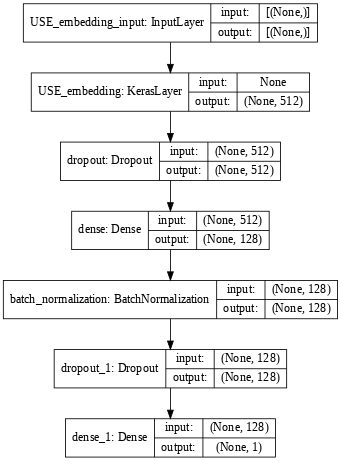

In [22]:
METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]


es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

#schedule = None
#schedule = PolynomialDecay(maxEpochs=epochs, initAlpha=init_lr, power=1)

#lrc = LearningRateScheduler(schedule)


optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )


#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    init_lr,
#    decay_steps=num_train_steps,
#    decay_rate=0.96,
#    staircase=True)

#optimizer = SGD(lr=init_lr, momentum=0.9,decay = 0.0)

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

###Train

In [23]:
#@title Load Model weights if available
#if os.path.exists(checkpoint_root_path) & len(os.listdir(checkpoint_root_path))>0:
#  print('loading saved weight')
#  classifier_model.load_weights(model_checkpoint_path)
#else:
#  print('No weight to initialize') 

In [24]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             callbacks=[es, mcb]
             )

Epoch 1/30
1217/1217 [==============================] - 270s 202ms/step - loss: 0.4546 - tp: 14844.0000 - fp: 4645.0000 - tn: 15148.0000 - fn: 4307.0000 - accuracy: 0.7701 - precision: 0.7617 - recall: 0.7751 - auc: 0.8653 - prc: 0.8661 - val_loss: 0.1750 - val_tp: 3691.0000 - val_fp: 211.0000 - val_tn: 4004.0000 - val_fn: 318.0000 - val_accuracy: 0.9357 - val_precision: 0.9459 - val_recall: 0.9207 - val_auc: 0.9806 - val_prc: 0.9806

Epoch 00001: val_loss improved from inf to 0.17503, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints/youtube_clickbait_finetuned_USE_all/youtube_clickbait_finetuned_USE_all_checkpoint
Epoch 2/30
1217/1217 [==============================] - 247s 203ms/step - loss: 0.1656 - tp: 17890.0000 - fp: 1156.0000 - tn: 18637.0000 - fn: 1261.0000 - accuracy: 0.9379 - precision: 0.9393 - recall: 0.9342 - auc: 0.9825 - prc: 0.9825 - val_loss: 0.1200 - val_tp: 3767.0000 - val_fp: 129.0000 - val_tn: 4086.000

#Plot train history

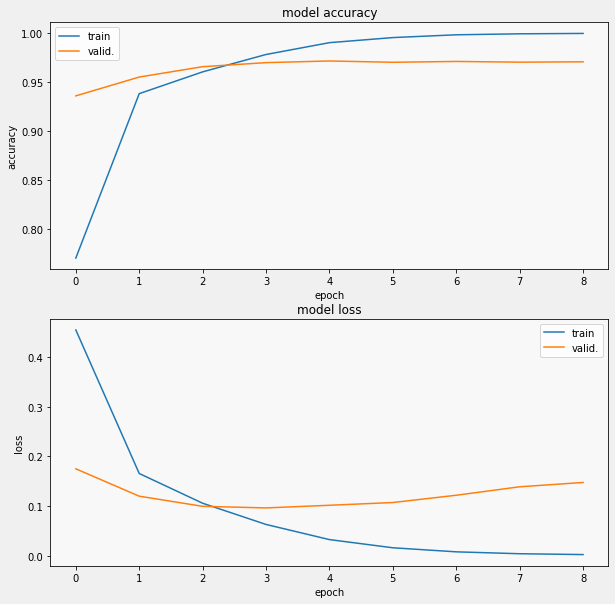

In [25]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

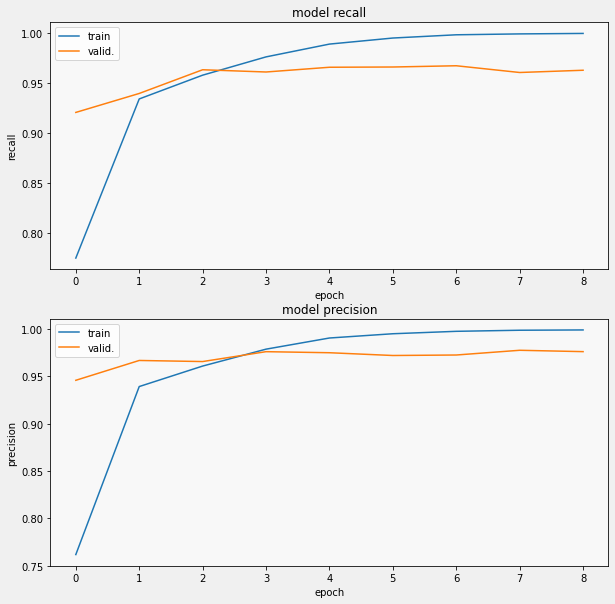

In [26]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

# Model Inference
We have trained the classifier, now let's use the trained model to infer the test dataset. Beside the test dataset, we also have benchmark dataset that we would also to see the eefectiveness of our model over benchmark dataset on predicting the clickbait's.

##Model Evaluation

###Evaluate Classifier on Test set

In [27]:
results_test_set = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results_test_set):
  print(name, ': ', value)
print()

60/60 [==============================] - 3s 31ms/step - loss: 0.0841 - tp: 876.0000 - fp: 32.0000 - tn: 991.0000 - fn: 21.0000 - accuracy: 0.9724 - precision: 0.9648 - recall: 0.9766 - auc: 0.9947 - prc: 0.9938
loss :  0.08405651897192001
tp :  876.0
fp :  32.0
tn :  991.0
fn :  21.0
accuracy :  0.9723958373069763
precision :  0.9647576808929443
recall :  0.9765886068344116
auc :  0.9947331547737122
prc :  0.9938437938690186



### Evaluate Classifier on Benchmarking set

In [33]:
results_benchmarking_set = classifier_model.evaluate(benchmark_ds)

for name, value in zip(classifier_model.metrics_names, results_benchmarking_set):
  print(name, ': ', value)
print()

5/5 [==============================] - 0s 26ms/step - loss: 1.0086 - tp: 45.0000 - fp: 4.0000 - tn: 62.0000 - fn: 49.0000 - accuracy: 0.6687 - precision: 0.9184 - recall: 0.4787 - auc: 0.8559 - prc: 0.9009
loss :  1.0085724592208862
tp :  45.0
fp :  4.0
tn :  62.0
fn :  49.0
accuracy :  0.668749988079071
precision :  0.918367326259613
recall :  0.478723406791687
auc :  0.855899453163147
prc :  0.9008941650390625



##Export Model for inference

In [29]:
#classifier_model.save(saved_model_path, include_optimizer=False)

##Model prediction

In [34]:
#saved_classifier = keras.models.load_model(saved_model_path)

### Prediction for Test set

Accuracy: 0.972396
Precision: 0.964758
Recall: 0.976589
F1 score: 0.970637
ROC AUC: 0.972654
[[991  32]
 [ 21 876]]
Non clickbaits Detected (True Negatives):  991
Non-Clickbaits Detected as Clickbaits (False Positives):  32
Clickbaits Detected as Non-clickbaits (False Negatives):  21
Clickbaits Detected (True Positives):  876
Total Non-clickbaits:  1023
Total Clickbaits:  897



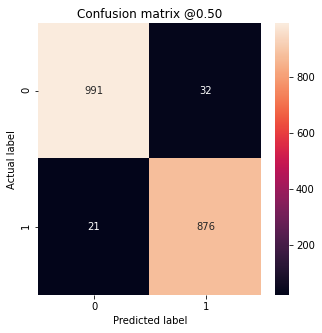

In [35]:
predict_on_test_dataset(classifier_model, test_ds, BATCH_SIZE=BATCH_SIZE)

### Prediction for Benchmarking set

Accuracy: 0.668750
Precision: 0.918367
Recall: 0.478723
F1 score: 0.629371
ROC AUC: 0.709059
[[62  4]
 [49 45]]
Non clickbaits Detected (True Negatives):  62
Non-Clickbaits Detected as Clickbaits (False Positives):  4
Clickbaits Detected as Non-clickbaits (False Negatives):  49
Clickbaits Detected (True Positives):  45
Total Non-clickbaits:  66
Total Clickbaits:  94



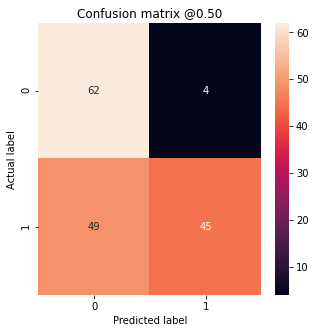

In [36]:
predict_on_test_dataset(classifier_model, benchmark_ds, BATCH_SIZE=BATCH_SIZE)